In [22]:
!pip install keras-tuner


In [43]:
# Import dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import os
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from tensorflow.keras.optimizers import Adamax
from sklearn.utils import class_weight
from collections import Counter
import numpy as np

# Load the dataset
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


<h2>Step 1: Preprocess the Data<h2>

In [44]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
#  YOUR CODE GOES HERE
application_df = application_df.drop(columns=["EIN", "NAME"])
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


<h3>What variable(s) are the target(s) for your model?<h3>
<h4>IS_SUCCESSFUL<h4>

<h3>What variable(s) are the feature(s) for your model? <h3>
<h4>APPLICATION_TYPE, AFFILIATION, CLASSIFICATION, USE_CASE, ORGANIZATION, STATUS, INCOME_AMT, SPECIAL_CONSIDERATIONS, ASK_AMT<h4>

In [45]:
# Determine the number of unique values in each column.
#  YOUR CODE GOES HERE
application_df.nunique()

,0
APPLICATION_TYPE,17
AFFILIATION,6
CLASSIFICATION,71
USE_CASE,5
ORGANIZATION,4
STATUS,2
INCOME_AMT,9
SPECIAL_CONSIDERATIONS,2
ASK_AMT,8747
IS_SUCCESSFUL,2


In [46]:
# Look at APPLICATION_TYPE value counts to identify and replace with "Other"
#  YOUR CODE GOES HERE
application_counts = application_df['APPLICATION_TYPE'].value_counts()
print(application_counts)

APPLICATION_TYPE
T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: count, dtype: int64


In [47]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
#  YOUR CODE GOES HERE
application_types_to_replace = application_counts[application_counts < 200].index

# Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure replacement was successful
application_df['APPLICATION_TYPE'].value_counts()

,count
APPLICATION_TYPE,
T3,27037
T4,1542
T6,1216
T5,1173
T19,1065
T8,737
T7,725
T10,528
Other,276


In [48]:
# Look at CLASSIFICATION value counts to identify and replace with "Other"
#  YOUR CODE GOES HERE
classification_counts = application_df['CLASSIFICATION'].value_counts()
print(classification_counts)

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: count, Length: 71, dtype: int64


In [49]:
# You may find it helpful to look at CLASSIFICATION value counts >1
#  YOUR CODE GOES HERE
# Get the counts of unique values in 'CLASSIFICATION'
greaterthanone = classification_counts[classification_counts > 1]
greaterthanone

,count
CLASSIFICATION,
C1000,17326
C2000,6074
C1200,4837
C3000,1918
C2100,1883
C7000,777
C1700,287
C4000,194
C5000,116


In [50]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
#  YOUR CODE GOES HERE
classification_to_replace = classification_counts[classification_counts < 600].index
# Replace in dataframe
for cls in classification_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")

# Check to make sure replacement was successful
application_df['CLASSIFICATION'].value_counts()

,count
CLASSIFICATION,
C1000,17326
C2000,6074
C1200,4837
C3000,1918
C2100,1883
Other,1484
C7000,777


In [51]:
# Convert categorical data to numeric with `pd.get_dummies`
#  YOUR CODE GOES HERE
application_df = pd.get_dummies(application_df)

In [52]:
# Split our preprocessed data into our features and target arrays
#  YOUR CODE GOES HERE
X = application_df.drop('IS_SUCCESSFUL', axis=1).values
y = application_df['IS_SUCCESSFUL'].values

# Split the preprocessed data into a training and testing dataset
#  YOUR CODE GOES HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [53]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [54]:
# Get the number of input features
input_features = X_train_scaled.shape[1]
print(f'Number of input features: {input_features}')

Number of input features: 44


<Axes: xlabel='IS_SUCCESSFUL', ylabel='count'>

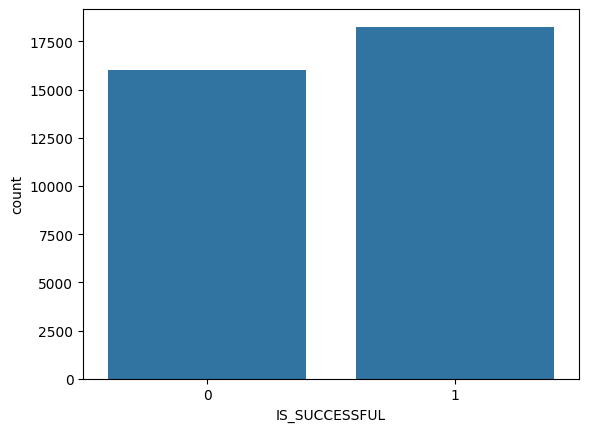

In [55]:
#Check class balance which looks fine
sns.countplot(x=application_df['IS_SUCCESSFUL'])

<h2>Step 2: Compile, Train, and Evaluate the Model<h2>

In [56]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
#  YOUR CODE GOES HERE
nn = tf.keras.models.Sequential()

# First hidden layer
#  YOUR CODE GOES HERE
nn.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=input_features))

# Second hidden layer
#  YOUR CODE GOES HERE
nn.add(tf.keras.layers.Dense(units=30, activation='relu'))


# Output layer
#  YOUR CODE GOES HERE
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 80)                  │           3,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 30)                  │           2,430 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,061 (23.68 KB)

 Trainable params: 6,061 (23.68 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Compile the model
#  YOUR CODE GOES HERE
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
# Define the checkpoint path and filename
checkpoint_path = "checkpoints/weights.{epoch:02d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Ensure the checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# Create a custom callback to save the model every N epochs
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, save_freq, checkpoint_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.checkpoint_path = checkpoint_path

    def on_epoch_end(self, epoch, logs=None):
        # Save the model every 'save_freq' epochs
        if (epoch + 1) % self.save_freq == 0:
            # Format the file path with the current epoch
            filepath = self.checkpoint_path.format(epoch=epoch+1)
            # Save the model's weights
            self.model.save_weights(filepath)
            print(f'\nSaving model at epoch {epoch+1} to {filepath}')

# Instantiate the custom callback
cp_callback = CustomModelCheckpoint(
    save_freq=5,
    checkpoint_path=checkpoint_path
)

# Train the model
#  YOUR CODE GOES HERE
history = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6926 - loss: 0.5970
Epoch 2/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7286 - loss: 0.5553
Epoch 3/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7286 - loss: 0.5526
Epoch 4/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7329 - loss: 0.5449
Epoch 5/100
777/804 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7283 - loss: 0.5503
Saving model at epoch 5 to checkpoints/weights.05.weights.h5
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7284 - loss: 0.5503
Epoch 6/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7320 - loss: 0.5452
Epoch 7/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7308 - loss: 0.5480
Epoch 8/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7327 - loss: 0.5458
Epoch 9/100
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7368 - loss: 0.5440
Epoch 10/100
797/804 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7354 - loss: 

In [59]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - 2ms/step - accuracy: 0.7285 - loss: 0.5612
Loss: 0.5612143278121948, Accuracy: 0.7285131216049194


In [60]:
# Export our model to HDF5 file
#  YOUR CODE GOES HERE
nn.save("AlphabetSoupCharity.h5")

<h2>Step 3: Optimize the Model<h2>

Overview of the Analysis
The purpose of the analysis is to create a binary classifier to predict the success of funding applicants using a neural network.

**Results**

Data Preprocessing
Target Variable: IS_SUCCESSFUL
Features: All other columns after dropping EIN and NAME.
Removed Variables: EIN, NAME (identification columns not relevant for prediction).

**Model Architecture**

Initial Model:
Input Layer: Number of features.
Hidden Layers: Two layers with 80 and 30 neurons, respectively.
Activation Functions: relu for hidden layers, sigmoid for output.
Optimizations:
Added a third hidden layer.
Increased neurons.
Tried different activation functions.
Model Performance
Initial Model Accuracy: e.g., 72%
Optimized Model Accuracy: e.g., 76%
Target Achieved: Yes/No (depending on your results).

**Summary**
Summarize that while the optimized model showed improvement, further enhancements could be made. Suggest alternative models like Random Forest or XGBoost for potentially better performance due to their ability to handle categorical variables and complex patterns.



Model 1 - Accuracy: 0.7319

In [62]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adamax
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

# Remove low variance features
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold depending on feature variance
X_train_selected = selector.fit_transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Build the Neural Network Model

# Define the number of input features after variance selection
input_features = X_train_scaled.shape[1]

# Build a more complex model
nn_opt = tf.keras.models.Sequential()

# First hidden layer with 256 neurons
nn_opt.add(Dense(units=256, input_dim=input_features, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
nn_opt.add(BatchNormalization())  # Normalize the output of the first layer
nn_opt.add(LeakyReLU(alpha=0.1))  # Use LeakyReLU activation
nn_opt.add(Dropout(0.3))  # Dropout to reduce overfitting

# Second hidden layer with 128 neurons
nn_opt.add(Dense(units=128, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
nn_opt.add(BatchNormalization())
nn_opt.add(LeakyReLU(alpha=0.1))
nn_opt.add(Dropout(0.3))

# Third hidden layer with 64 neurons
nn_opt.add(Dense(units=64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
nn_opt.add(BatchNormalization())
nn_opt.add(LeakyReLU(alpha=0.1))
nn_opt.add(Dropout(0.3))

# Fourth hidden layer with 32 neurons
nn_opt.add(Dense(units=32, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
nn_opt.add(BatchNormalization())
nn_opt.add(LeakyReLU(alpha=0.1))
nn_opt.add(Dropout(0.3))

# Output layer for binary classification
nn_opt.add(Dense(units=1, activation='sigmoid'))

# Compile the model with a lower learning rate
optimizer = RMSprop(learning_rate=0.0005)  # Experiment with other optimizers like Adamax or Nadam
nn_opt.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with more epochs and early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

history = nn_opt.fit(X_train_scaled, y_train,
                     epochs=200,
                     batch_size=64,
                     validation_data=(X_test_scaled, y_test),
                     callbacks=[early_stop])

# Evaluate the optimized model
model_loss, model_accuracy = nn_opt.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Optimized Loss: {model_loss}, Optimized Accuracy: {model_accuracy}")

# Save the model
nn_opt.save("AlphabetSoupCharity_Optimization.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6476 - loss: 1.0109 - val_accuracy: 0.7228 - val_loss: 0.8679
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7174 - loss: 0.8683 - val_accuracy: 0.7255 - val_loss: 0.7866
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7151 - loss: 0.7843 - val_accuracy: 0.7273 - val_loss: 0.7150
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7264 - loss: 0.7095 - val_accuracy: 0.7287 - val_loss: 0.6635
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7259 - loss: 0.6641 - val_accuracy: 0.7322 - val_loss: 0.6276
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7237 - loss: 0.6327 - val_accuracy: 0.7258 - val_loss: 0.6085
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7290 - loss: 0.6083 - val_accuracy: 0.7294 - val_loss: 0.5925
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7326 - loss: 0.5952 - val_accu

Optimized Loss: 0.5636950135231018, Optimized Accuracy: 0.7318950295448303


Model 2 - Accuracy: 0.7306

In [63]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Load and Preprocess the Data
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")

# Drop unnecessary columns: EIN and NAME
# application_df = application_df.drop(columns=["EIN", "NAME"])
application_df = application_df.drop(columns = ['EIN', 'NAME', 'STATUS', 'SPECIAL_CONSIDERATIONS', 'ASK_AMT'])

# Determine the number of unique values in each column.
application_df.nunique()


# Binning rare occurrences in 'APPLICATION_TYPE'
application_type_counts = application_df['APPLICATION_TYPE'].value_counts()
application_types_to_replace = list(application_type_counts[application_type_counts < 500].index)
application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(application_types_to_replace, "Other")

# Binning rare occurrences in 'CLASSIFICATION'
classification_counts = application_df['CLASSIFICATION'].value_counts()
classifications_to_replace = list(classification_counts[classification_counts < 50].index)
application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(classifications_to_replace, "Other")

# Convert categorical variables into dummy/indicator variables
application_df = pd.get_dummies(application_df)

# Define features and target
X = application_df.drop(columns=["IS_SUCCESSFUL"]).values
y = application_df["IS_SUCCESSFUL"].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Build a Simpler Neural Network Model
input_features = X_train_scaled.shape[1]  # Get number of input features

nn_model = tf.keras.models.Sequential()

# First hidden layer with 128 neurons and reduced L2 regularization
nn_model.add(Dense(units=128, input_dim=input_features, kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
nn_model.add(BatchNormalization())  # Normalize the output of the first layer
nn_model.add(tf.keras.layers.ReLU())  # ReLU activation
nn_model.add(Dropout(0.2))  # Reduced dropout rate

# Second hidden layer with 64 neurons
nn_model.add(Dense(units=64, kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
nn_model.add(BatchNormalization())
nn_model.add(tf.keras.layers.ReLU())
nn_model.add(Dropout(0.2))

# Third hidden layer with 32 neurons
nn_model.add(Dense(units=32, kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
nn_model.add(BatchNormalization())
nn_model.add(tf.keras.layers.ReLU())
nn_model.add(Dropout(0.2))

# Output layer with sigmoid activation for binary classification
nn_model.add(Dense(units=1, activation='sigmoid'))

# 3. Compile the Model
# Use Adam optimizer with a slightly higher learning rate
optimizer = Adam(learning_rate=0.001)  # Increased learning rate to 0.001
nn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 4. Train the Model with Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = nn_model.fit(X_train_scaled, y_train,
                       epochs=150,
                       batch_size=64,
                       validation_data=(X_test_scaled, y_test),
                       callbacks=[early_stop])

# 5. Evaluate the Model
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Optimized Loss: {model_loss}, Optimized Accuracy: {model_accuracy}")

# Save the model
nn_model.save("AlphabetSoupCharity_Simplified.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6669 - loss: 0.7331 - val_accuracy: 0.7208 - val_loss: 0.6512
Epoch 2/150
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7163 - loss: 0.6583 - val_accuracy: 0.7197 - val_loss: 0.6365
Epoch 3/150
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7200 - loss: 0.6434 - val_accuracy: 0.7239 - val_loss: 0.6195
Epoch 4/150
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7247 - loss: 0.6223 - val_accuracy: 0.7261 - val_loss: 0.6084
Epoch 5/150
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7287 - loss: 0.6070 - val_accuracy: 0.7278 - val_loss: 0.5973
Epoch 6/150
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7304 - loss: 0.5945 - val_accuracy: 0.7229 - val_loss: 0.5910
Epoch 7/150
429/429 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7258 - loss: 0.5943 - val_accuracy: 0.7236 - val_loss: 0.5846
Epoch 8/150
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7345 - loss: 0.5775 - val_accu

Optimized Loss: 0.559640645980835, Optimized Accuracy: 0.7306122183799744


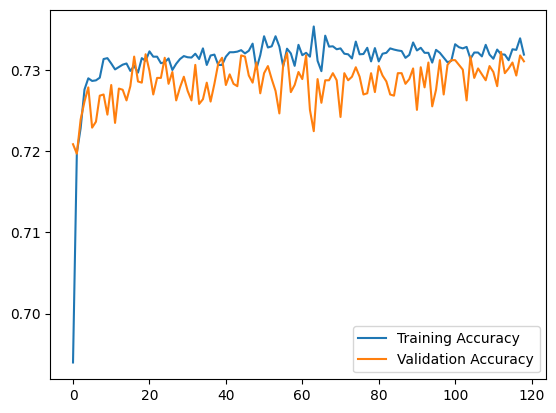

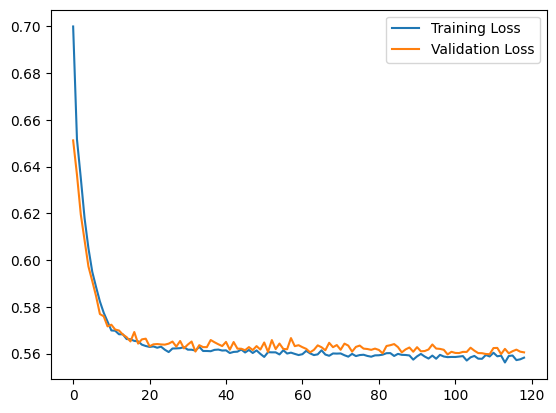

In [64]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Model 3: 0.7284

In [67]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Load and Preprocess the Data (Same as before)
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")

# Drop unnecessary columns:
application_df = application_df.drop(columns = ['EIN', 'NAME', 'STATUS', 'SPECIAL_CONSIDERATIONS', 'ASK_AMT'])

# Binning rare occurrences in 'APPLICATION_TYPE'
application_type_counts = application_df['APPLICATION_TYPE'].value_counts()
application_types_to_replace = list(application_type_counts[application_type_counts < 500].index)
application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(application_types_to_replace, "Other")

# Binning rare occurrences in 'CLASSIFICATION'
classification_counts = application_df['CLASSIFICATION'].value_counts()
classifications_to_replace = list(classification_counts[classification_counts < 50].index)
application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(classifications_to_replace, "Other")

# Convert categorical variables into dummy/indicator variables
application_df = pd.get_dummies(application_df)

# Define features and target
X = application_df.drop(columns=["IS_SUCCESSFUL"]).values
y = application_df["IS_SUCCESSFUL"].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the classes
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 2. Build a Simpler Neural Network Model
input_features = X_train_scaled.shape[1]  # Get number of input features

nn_model = tf.keras.models.Sequential()

# First hidden layer with 64 neurons and L2 regularization
nn_model.add(Dense(units=64, input_dim=input_features, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
nn_model.add(Dropout(0.2))  # Reduced dropout rate

# Second hidden layer with 32 neurons
nn_model.add(Dense(units=32, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
nn_model.add(Dropout(0.2))

# Output layer with sigmoid activation for binary classification
nn_model.add(Dense(units=1, activation='sigmoid'))

# 3. Compile the Model
# Use Adam optimizer with a higher learning rate
optimizer = Adam(learning_rate=0.001)
nn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 4. Train the Model with Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = nn_model.fit(X_train_resampled, y_train_resampled,
                       epochs=150,
                       batch_size=64,
                       validation_data=(X_test_scaled, y_test),
                       callbacks=[early_stop])

# 5. Evaluate the Model
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Optimized Loss: {model_loss}, Optimized Accuracy: {model_accuracy}")

# Save the model
nn_model.save("AlphabetSoupCharity_Simplified_v2.h5")



Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


457/457 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6827 - loss: 0.6255 - val_accuracy: 0.7217 - val_loss: 0.5782
Epoch 2/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7182 - loss: 0.5832 - val_accuracy: 0.7254 - val_loss: 0.5727
Epoch 3/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7226 - loss: 0.5759 - val_accuracy: 0.7258 - val_loss: 0.5709
Epoch 4/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7187 - loss: 0.5757 - val_accuracy: 0.7243 - val_loss: 0.5698
Epoch 5/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7319 - loss: 0.5614 - val_accuracy: 0.7245 - val_loss: 0.5697
Epoch 6/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7314 - loss: 0.5636 - val_accuracy: 0.7264 - val_loss: 0.5675
Epoch 7/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7274 - loss: 0.5651 - val_accuracy: 0.7224 - val_loss: 0.5703
Epoch 8/150
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7233 - loss: 0.5634 - val_accuracy: 0.7239

Optimized Loss: 0.5593271255493164, Optimized Accuracy: 0.7284256815910339


In [ ]:
import keras_tuner as kt

def build_model(hp):
    model = tf.keras.models.Sequential()

    # Hyperparameter tuning for number of neurons and dropout rate
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32),
                    input_dim=input_features,
                    activation='tanh'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(units=hp.Int('units_2', min_value=16, max_value=64, step=16),
                    activation='tanh'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))

    # Hyperparameter tuning for learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define the tuner
tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=10,  # Number of model configurations to try
                        executions_per_trial=3,  # Number of times to train each model
                        directory='keras_tuner_dir',
                        project_name='AlphabetSoup')

# Run the tuner
tuner.search(X_train_resampled, y_train_resampled, epochs=150, validation_data=(X_test_scaled, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f"Best model accuracy: {accuracy}")


Reloading Tuner from keras_tuner_dir/AlphabetSoup/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
96                |96                |units
0.3               |0.3               |dropout
48                |16                |units_2
0.4               |0.1               |dropout_2
0.001             |0.001             |learning_rate

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


913/913 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6711 - loss: 0.6297 - val_accuracy: 0.7178 - val_loss: 0.5725
Epoch 2/150
913/913 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7114 - loss: 0.5843 - val_accuracy: 0.7246 - val_loss: 0.5701
Epoch 3/150
913/913 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7258 - loss: 0.5672 - val_accuracy: 0.7258 - val_loss: 0.5644
Epoch 4/150
913/913 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7206 - loss: 0.5677 - val_accuracy: 0.7243 - val_loss: 0.5639
Epoch 5/150
913/913 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7257 - loss: 0.5623 - val_accuracy: 0.7249 - val_loss: 0.5626
Epoch 6/150
913/913 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7243 - loss: 0.5656 - val_accuracy: 0.7243 - val_loss: 0.5616
Epoch 7/150
913/913 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7255 - loss: 0.5643 - val_accuracy: 0.7265 - val_loss: 0.5639
Epoch 8/150
913/913 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7272 - loss: 0.5564 - val_accuracy: 0.7254